## Load libraries
- python 3.7.3
- networkx 2.3
- pandas 0.24.2
- numpy 1.16.3
- matplotlib 3.1.0
- seaborn 0.9.0
- community 0.13 (python-louvain is the package name)

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import community

In [2]:
# Get rid of warning information
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set Seaborn styles for better looking figures
sns.set_palette("Accent")
sns.set_context(context='paper')

In [4]:
cos_mx = pd.read_excel("./datasets/Cos-reduced-normalized.xlsx")
cos_mx = cos_mx.drop(columns='Unnamed: 0')

In [5]:
for i in [25,50,70, 75, 90]:
    print("percentile", i, np.percentile(cos_mx.values,i))

percentile 25 0.05138122675111305
percentile 50 0.2374975798274612
percentile 70 0.3879425531021462
percentile 75 0.4275216501626078
percentile 90 0.6246927341373489


In [6]:
## load .xlsx info
property_mx = pd.read_excel("./datasets/Reduced_with-real-values.xlsx")
property_mx = property_mx.drop(columns='Unnamed: 0')

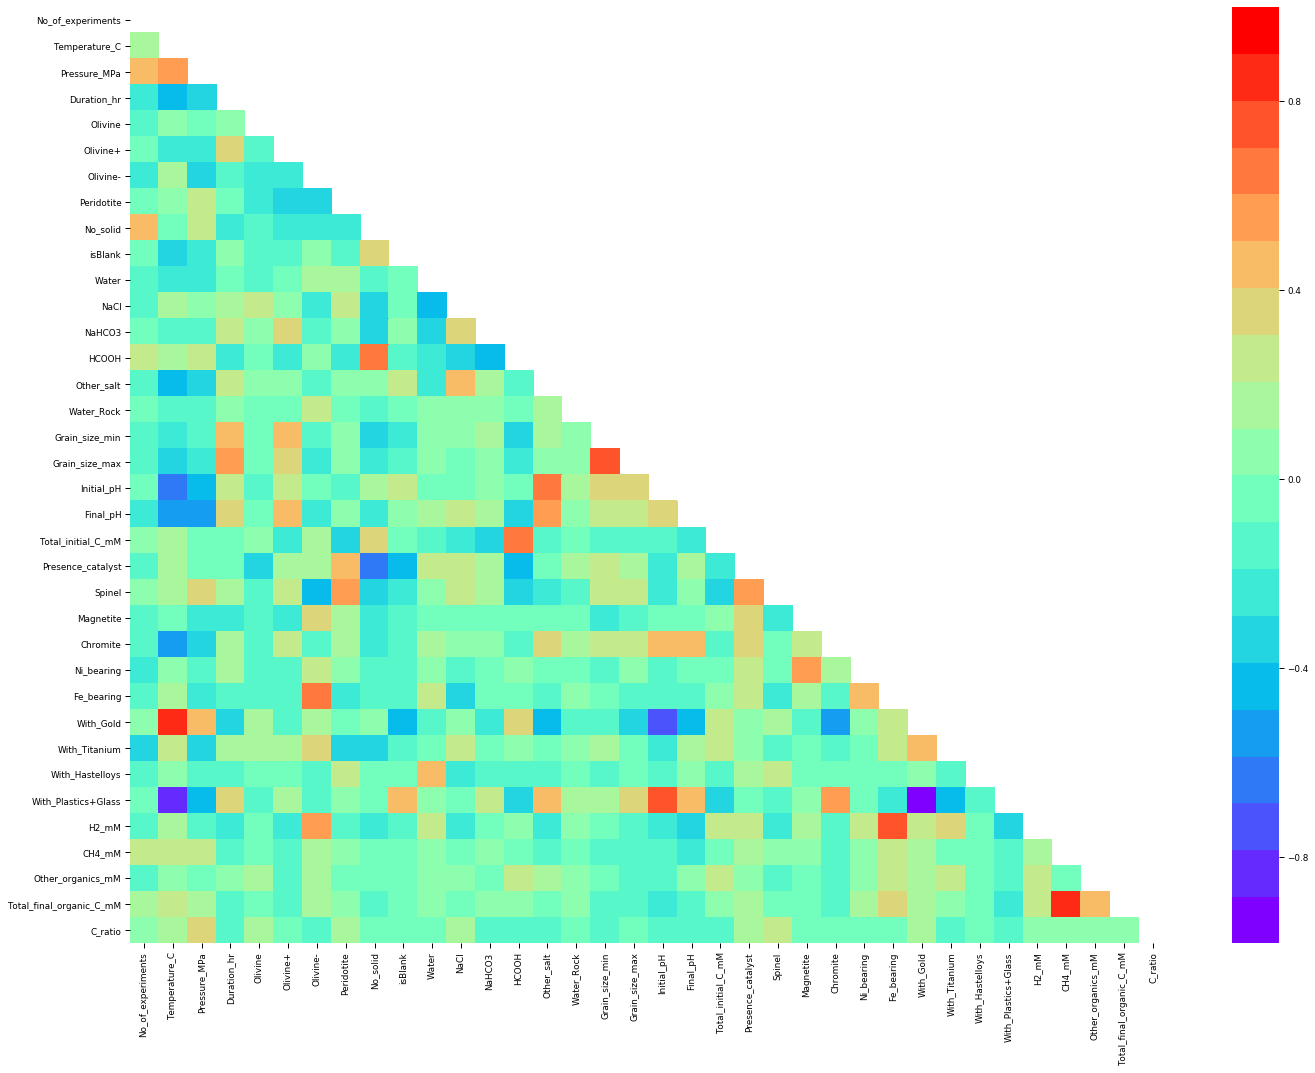

In [7]:
corr = property_mx.corr()
plt.figure(figsize=(20,15))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

cmap = mpl.cm.get_cmap('rainbow', 20)

# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=cmap, mask=mask)
plt.tight_layout()
plt.tick_params(direction='out', top=False, right=False)

plt.savefig('./figures/covariance.png')

In [8]:
# set threshold - to remove the weakeast 70% of the edges
# further analysis on threshold can be seen in the sensitivity analysis
threshold = 0.39
cos_mx = cos_mx.where(cos_mx > threshold, 0)

### Build the network

In [9]:
G = nx.Graph()

nodes = list(cos_mx.index)
edges = []

for i in cos_mx.index:
    for j in range(i+1):
        if cos_mx.iloc[i,j] > 0:
            edges.append([i, j, cos_mx.iloc[i,j]])

# add nodes and edges to network
G.add_nodes_from(nodes)            
G.add_weighted_edges_from(edges)

### Determine the layout of the graph

In [10]:
pos = nx.spring_layout(G,seed=103)
plt.style.use('classic')

### Define the graph plot function

In [11]:
def graphplot(G, colname, pos, color='Wistia', isLog=True, nodes=nodes, edges=edges, ratio=False):
    node_col = np.array(property_mx[colname])
    col_cmap = mpl.cm.get_cmap(color, 10)
    if isLog:
        col_norm = mpl.colors.LogNorm(vmin = min(node_col[node_col > 0]), vmax = max(node_col))
    elif ratio:
         col_norm = mpl.colors.Normalize(vmin = min(node_col[node_col > 0]), vmax = 1)
    else:
        col_norm = mpl.colors.Normalize(vmin = min(node_col[node_col > 0]), vmax = max(node_col))
        
    node_colors = []
    if not ratio:
        for i, v in enumerate(node_col):
            if v > 0: #make sure temp exists
                node_colors.append(col_cmap(col_norm(v))) #color node based on temp
            elif v < 0: #color node red
                node_colors.append((1, 0, 0))
            else: #color node white
#                 if colname is 'Other_organics_mM' or 'Total_final_organic_C_mM':
#                     node_colors.append((1, 0, 0))
#                 else:
                node_colors.append((1, 1, 1))
    else:
        for i, v in enumerate(node_col):
            if v <= 1 and v > 0: #make sure temp exists
                node_colors.append(col_cmap(col_norm(v))) #color node based on temp
            elif v < 0: #color node
                node_colors.append((1, 0, 0))
            elif v == 0: #color node white
                node_colors.append((1, 1, 1))
            else: #color node dard red (contamination)
                node_colors.append((1, 0.62, 0))#(0, 0, 1))

            
    plt.figure(figsize=(8,8)) #Increase graph size
    nx.draw_networkx(G, pos, nodelist = nodes, edgelist = edges, with_labels = False, node_color = node_colors, alpha = 1)
    nx.draw_networkx_labels(G, pos, font_size = 10)
    plt.axis('off')
    plt.margins(0.1)

    #Draw colorbar
    sm = plt.cm.ScalarMappable(cmap=col_cmap, norm=col_norm)
    sm._A = []
    cb = plt.colorbar(sm, fraction=0.05, pad=0.02, aspect = 5)
    cb.set_label(colname)   
    plt.savefig('./figures/{}.png'.format(colname), transparent=True)
    plt.show()


In [12]:
binaryList = ['Olivine', 'Olivine+', 'Olivine-', 'Peridotite','No_solid', 
              'isBlank', 'Water', 'NaCl', 'NaHCO3', 'HCOOH', 'Other_salt',
              'Presence_catalyst', 'Spinel','Magnetite', 'Chromite', 'Ni_bearing', 
              'Fe_bearing', 'With_Gold', 'With_Titanium', 'With_Hastelloys', 
              'With_Plastics+Glass']
nonLogList = ['Initial_pH', 'Final_pH']

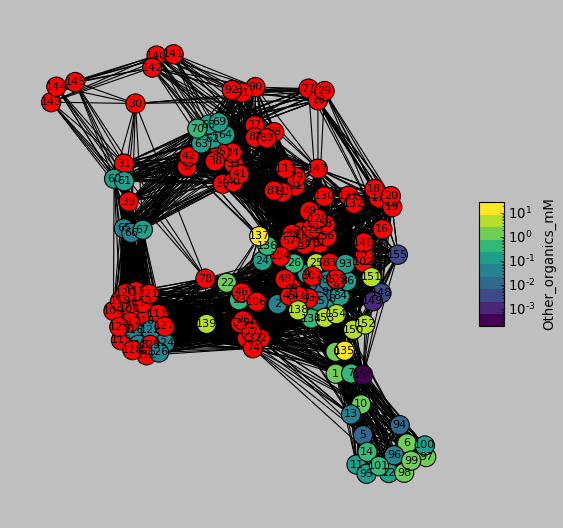

In [13]:
graphplot(G, 'Other_organics_mM', pos, isLog=True, color='viridis')

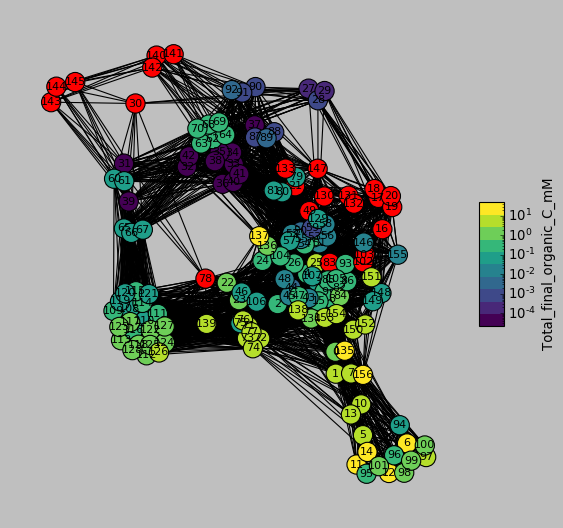

In [14]:
graphplot(G, 'Total_final_organic_C_mM', pos, isLog=True, color='viridis')

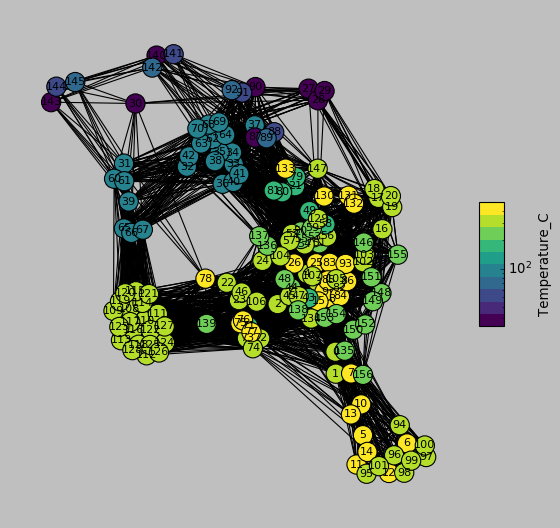

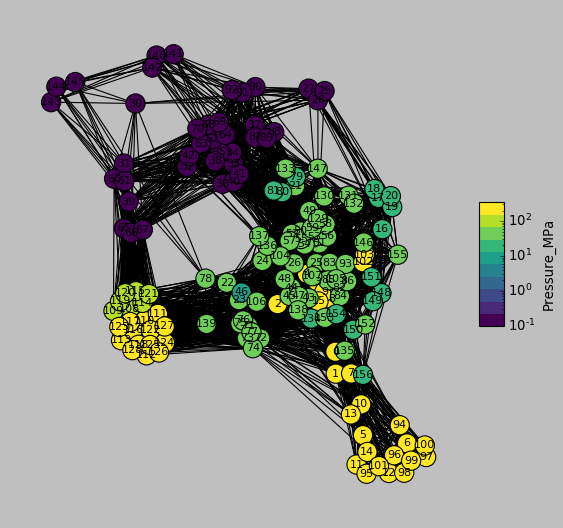

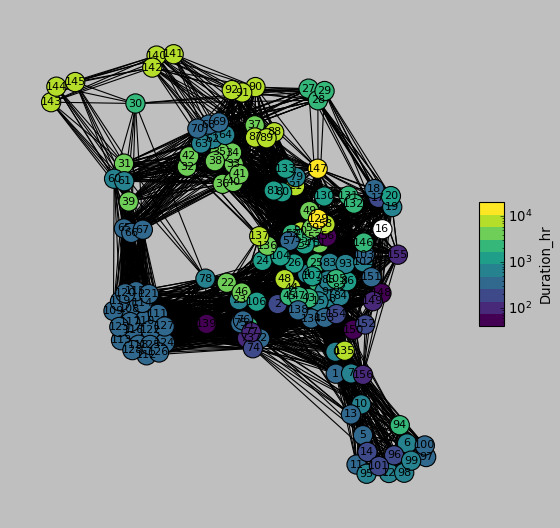

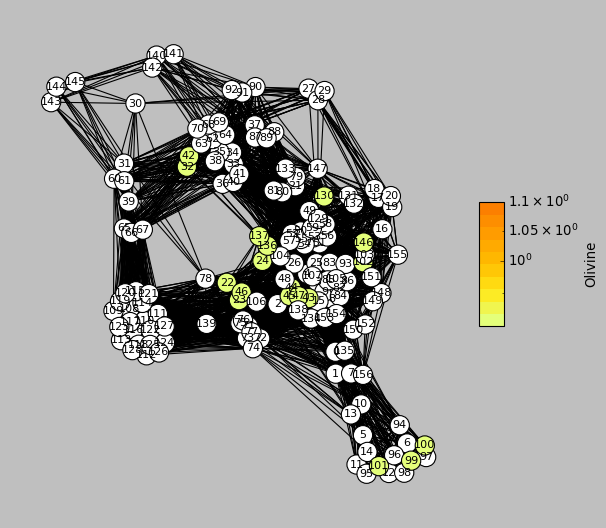

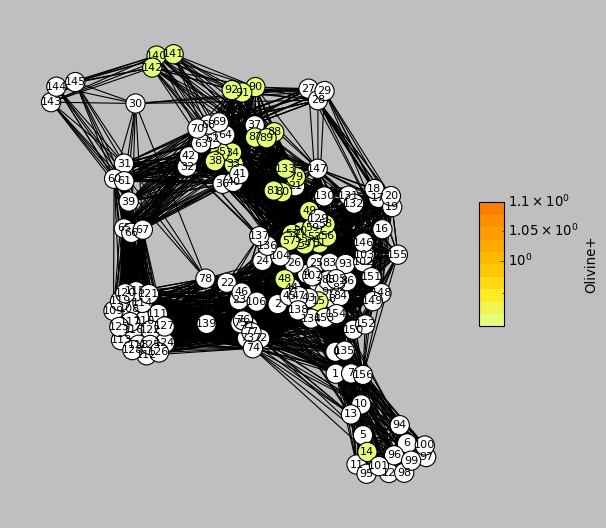

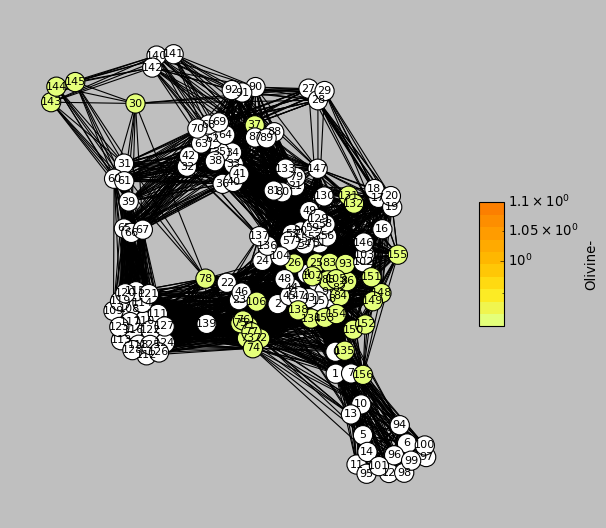

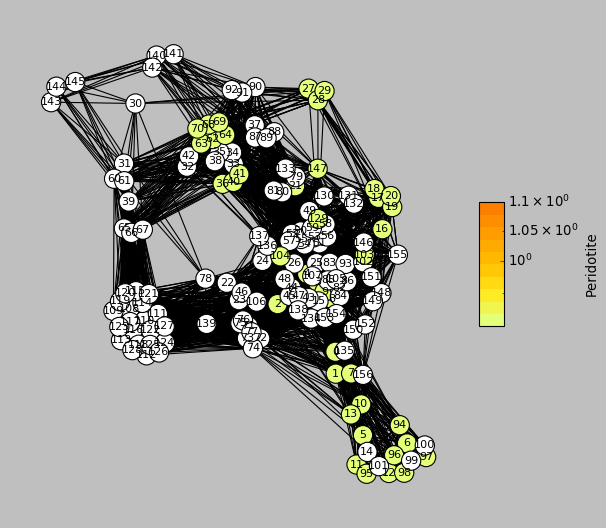

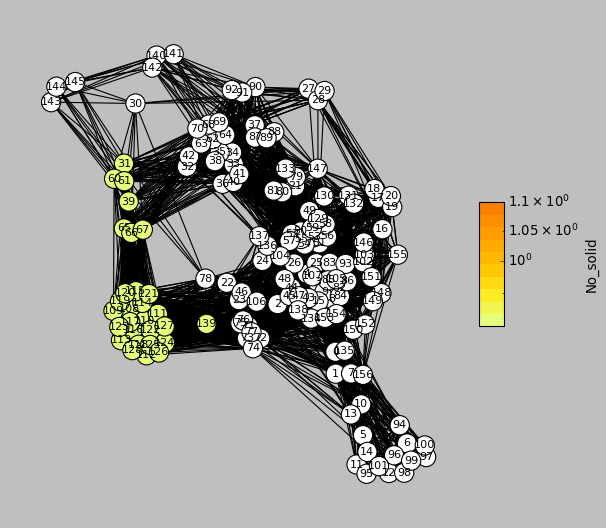

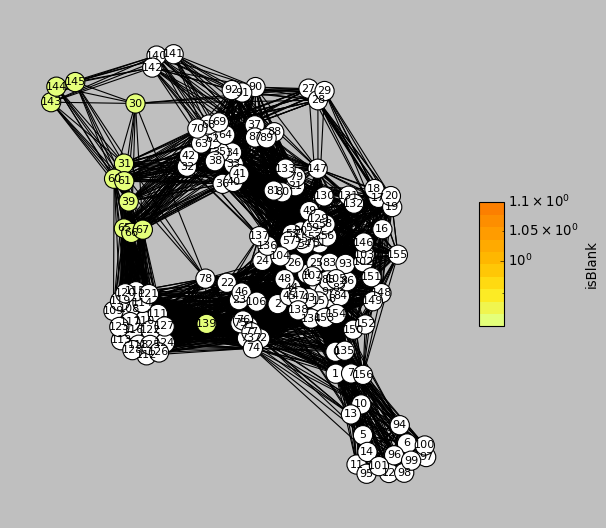

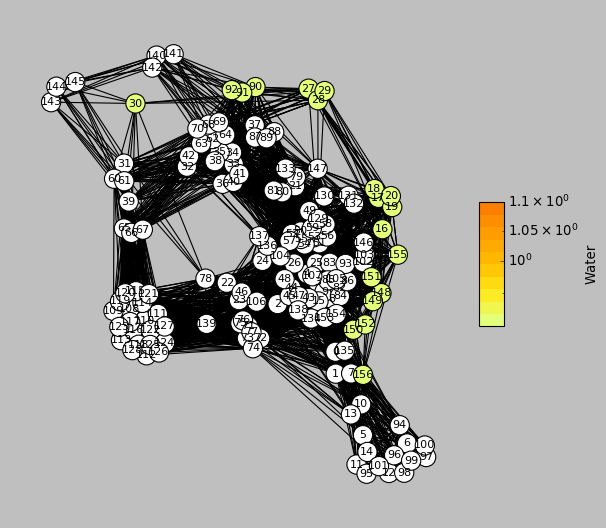

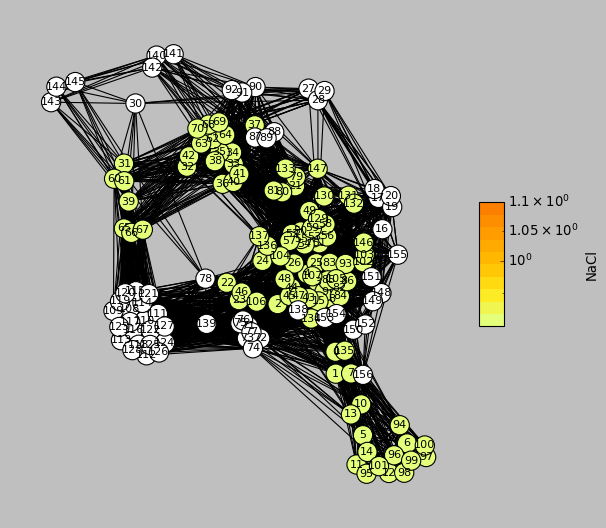

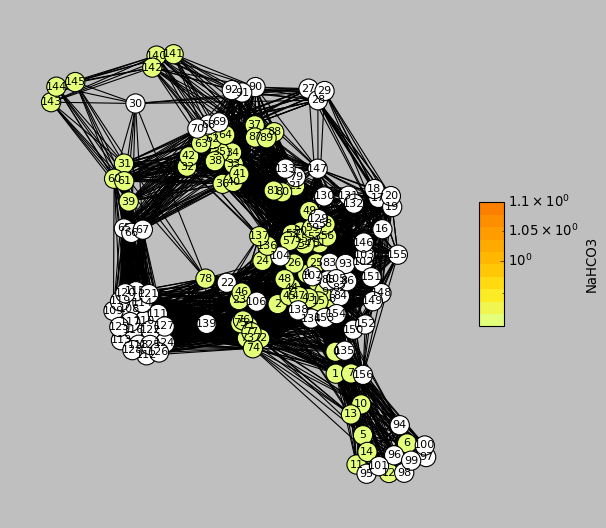

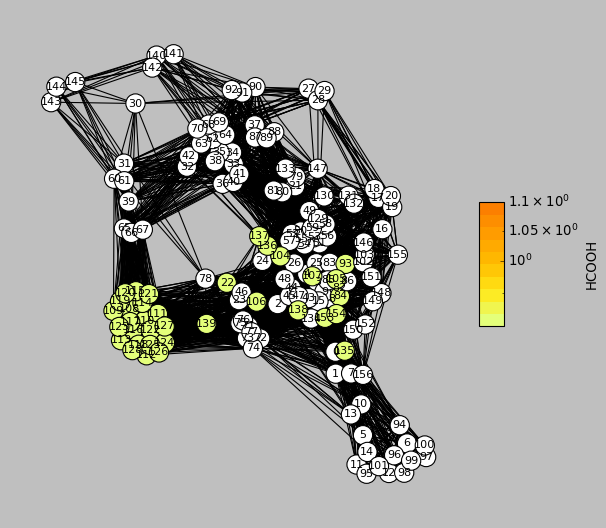

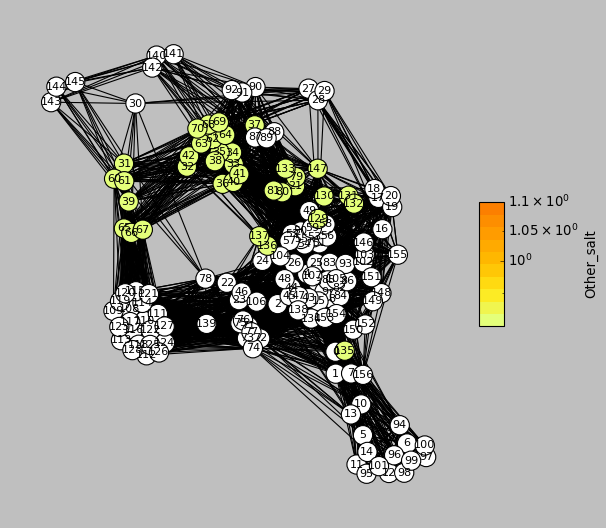

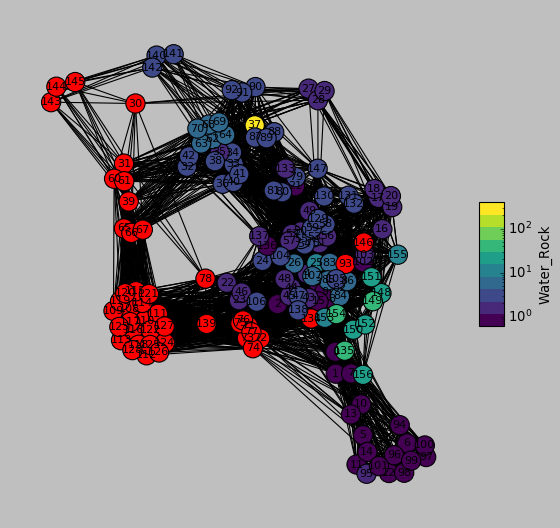

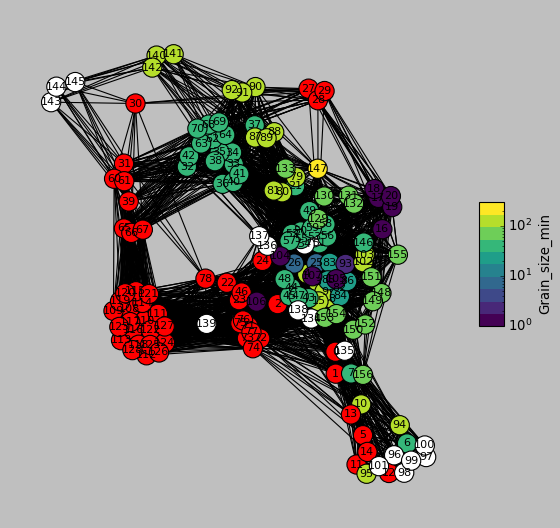

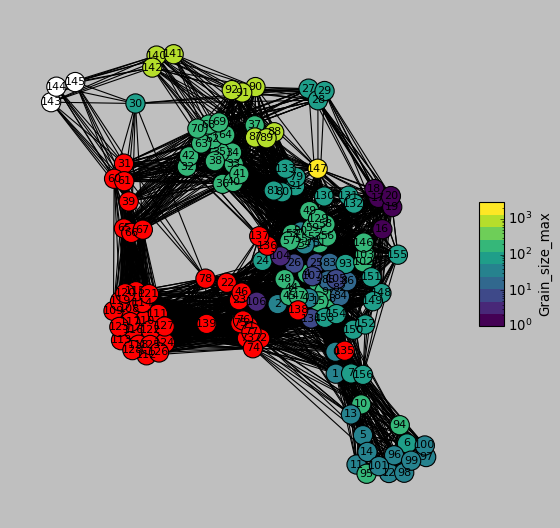

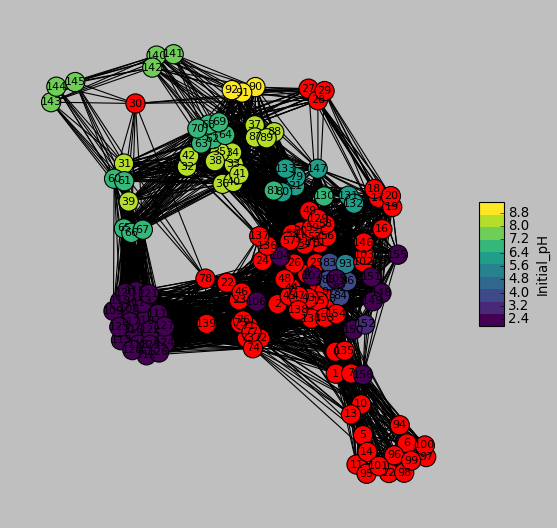

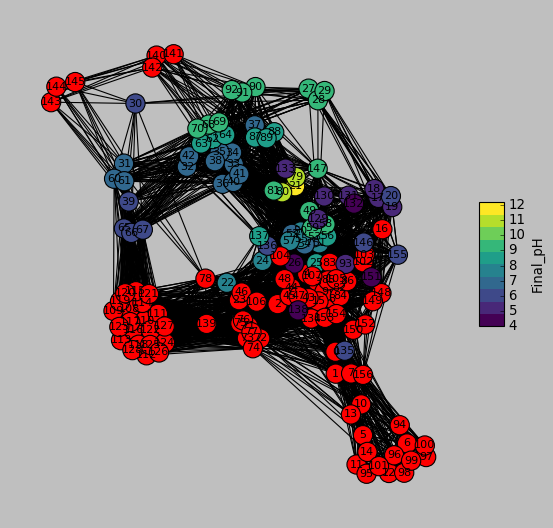

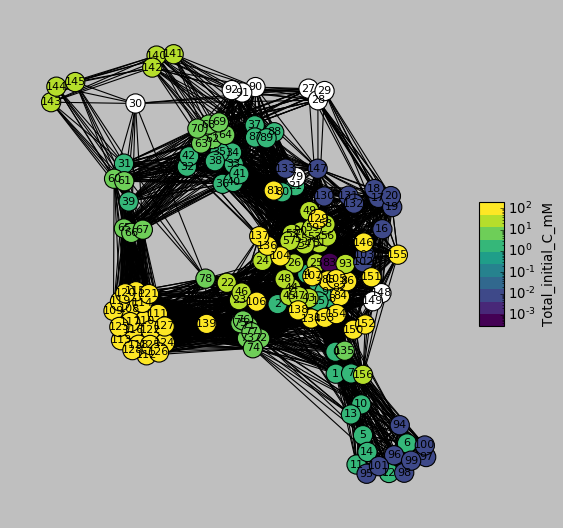

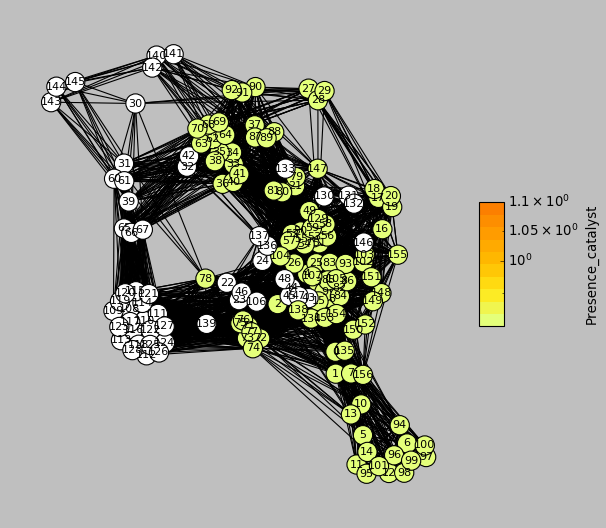

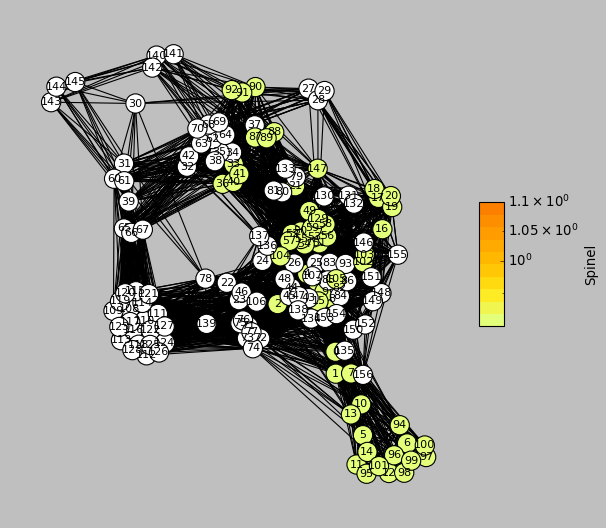

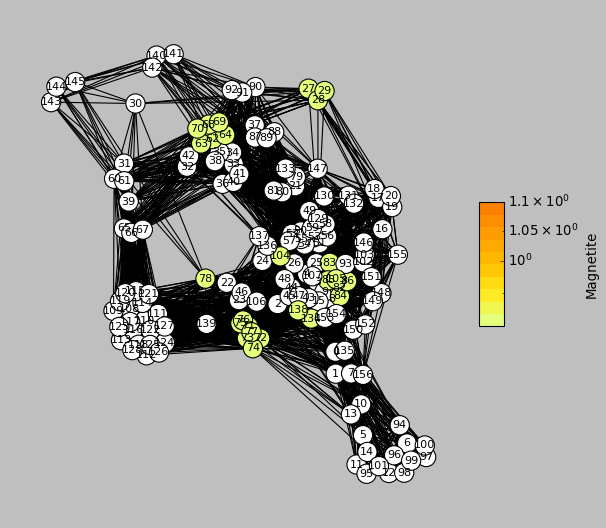

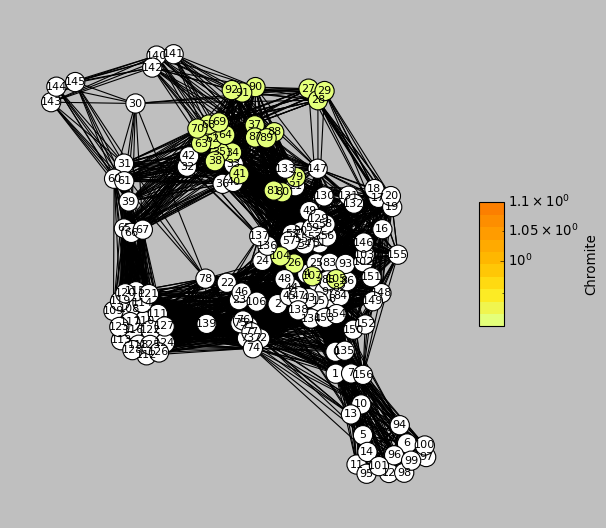

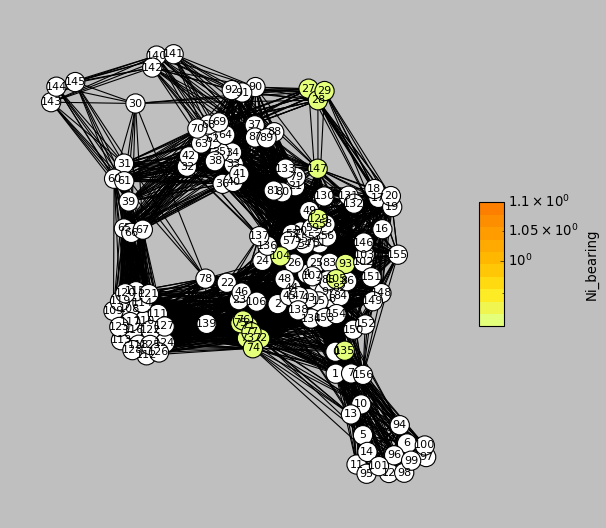

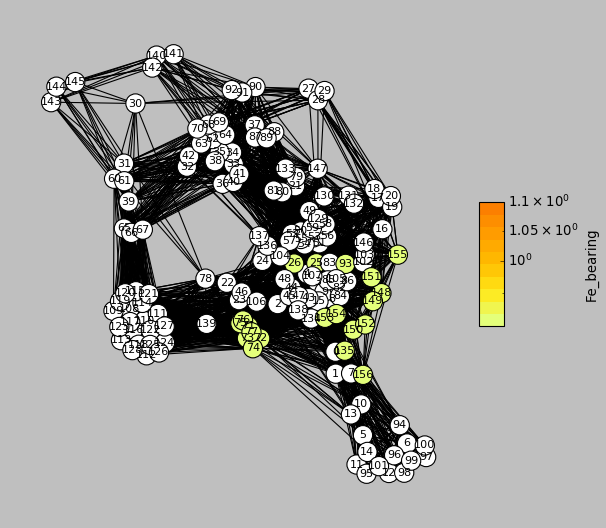

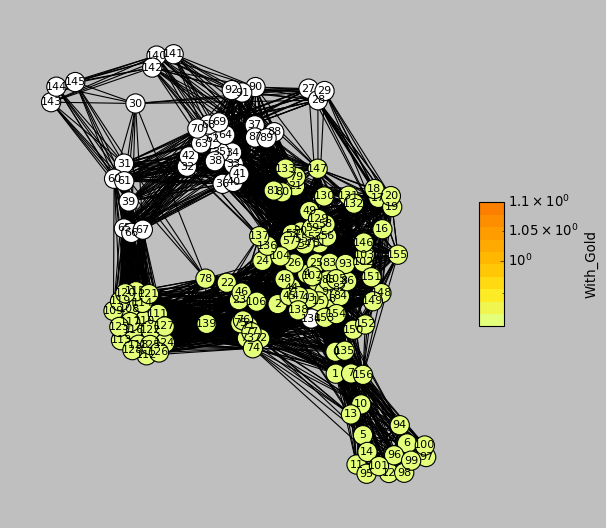

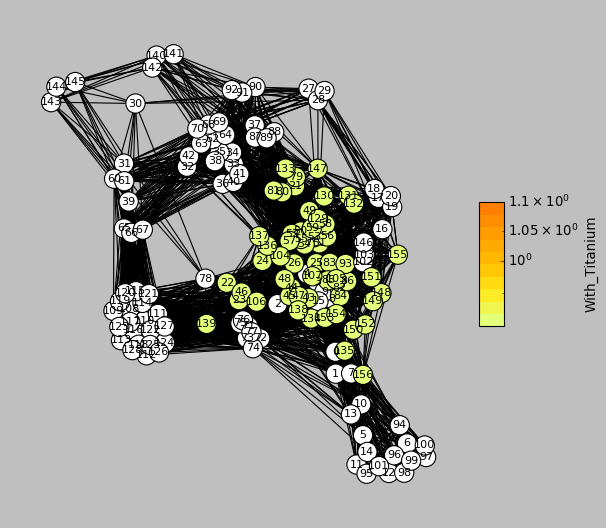

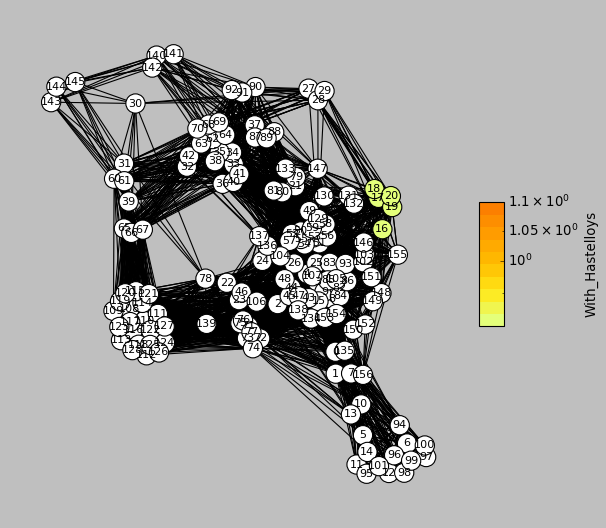

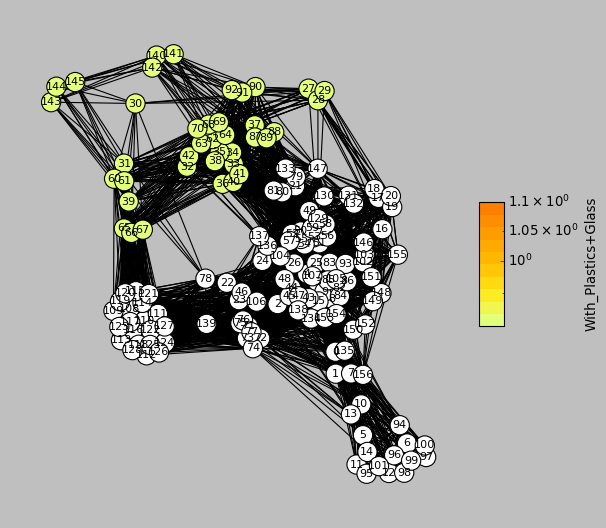

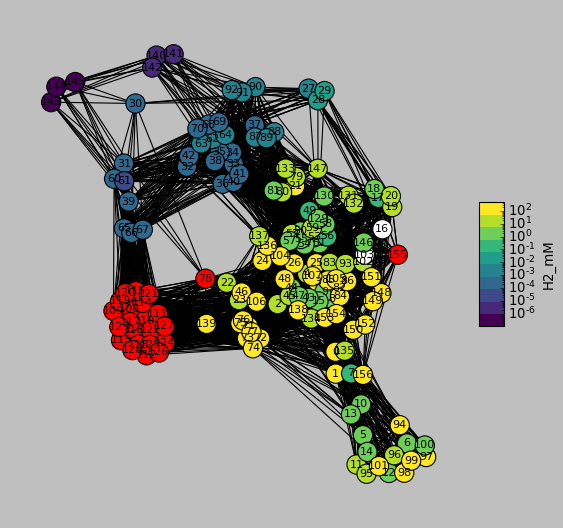

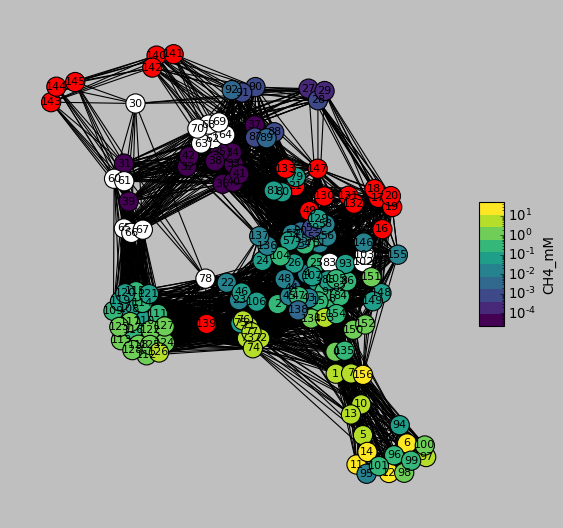

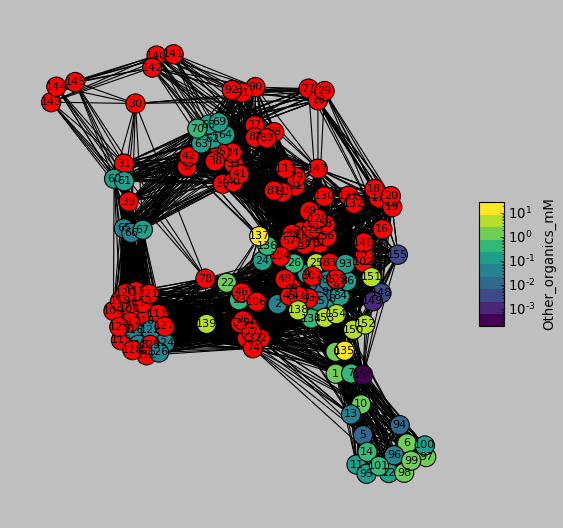

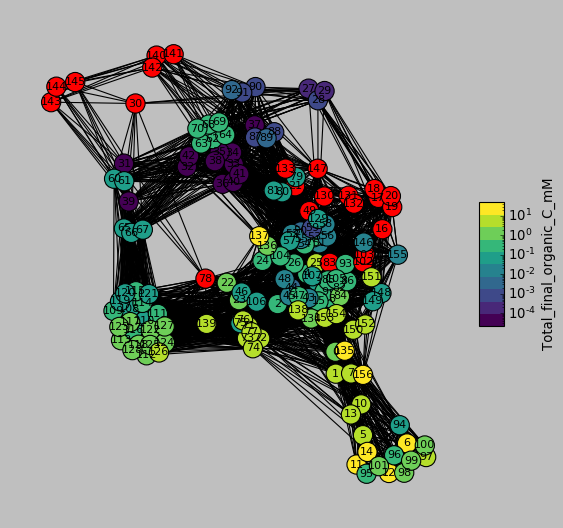

In [15]:
for i in range(2,36):
    col = property_mx.columns[i]
    isLog = True
    color = 'viridis'
    if col in binaryList:
        color = 'Wistia'
    if col in nonLogList:
        isLog = False
    graphplot(G, col, pos, color=color, isLog=isLog)

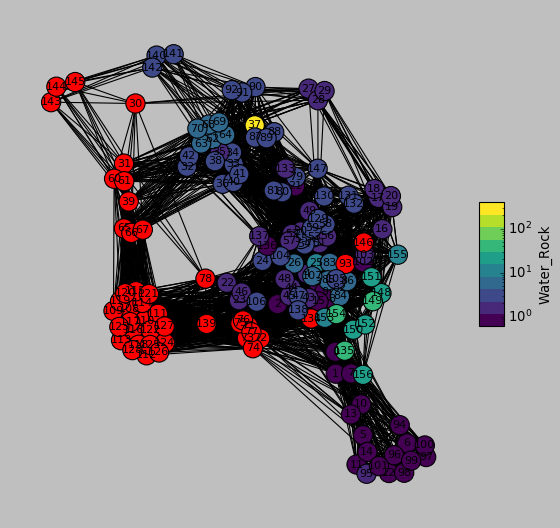

In [16]:
graphplot(G, 'Water_Rock', pos, isLog=True, color='viridis')

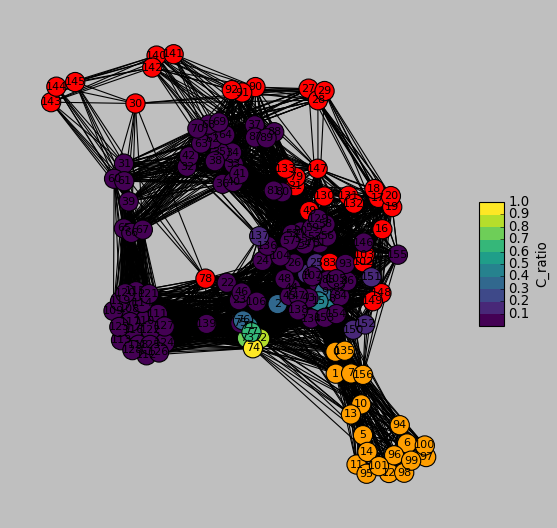

In [17]:
graphplot(G, 'C_ratio', pos, color='viridis', isLog=False, ratio=True)

## Community detection

In [18]:
dfreal = pd.read_excel('./datasets/Reduced_with-real-values.xlsx')
dfreal = dfreal.drop(columns='Unnamed: 0')

29


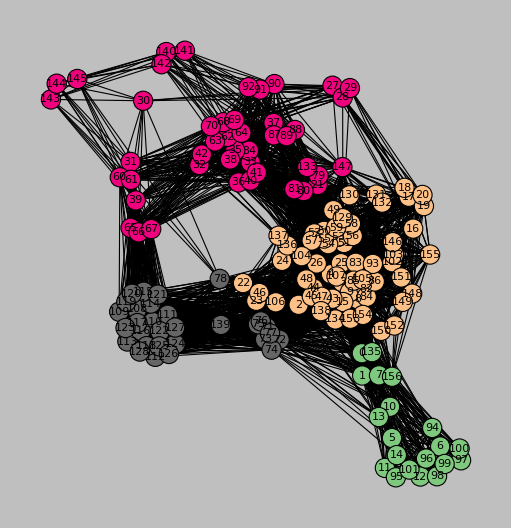

In [19]:
for i in range(29,30):
    print(i)
    part = community.best_partition(G, random_state=i)
    values = [part.get(node) for node in G.nodes()]


    dfreal['Community_number'] = pd.Series(part)
    property_mx['Community_number'] = pd.Series(part)

    pos = nx.spring_layout(G,seed=103)
    #Draw graph
    plt.figure(figsize=(8,8)) #Increase graph size
    nx.draw_networkx(G, pos, nodelist = nodes, edgelist = edges,
                     with_labels = False, node_color = values, alpha = 1, cmap = "Accent")
    nx.draw_networkx_labels(G, pos, font_size = 10)
    plt.axis("off")
#     plt.title("Experiments communities")
    plt.margins(0.09)

    plt.savefig('./figures/Community.png',transparent=True)
    plt.show()

In [20]:
dfreal.to_excel('./datasets/Reduced_with-real-values-community.xlsx')

### Swarmplot

In [23]:
ind = ['Temperature_C', 'Pressure_MPa','Duration_hr','Water_Rock', 'Grain_size_min', 'Grain_size_max', 'Initial_pH',
       'Final_pH', 'Total_initial_C_mM','H2_mM','CH4_mM', 'Other_organics_mM', 'Total_final_organic_C_mM',
       'C_ratio' ]

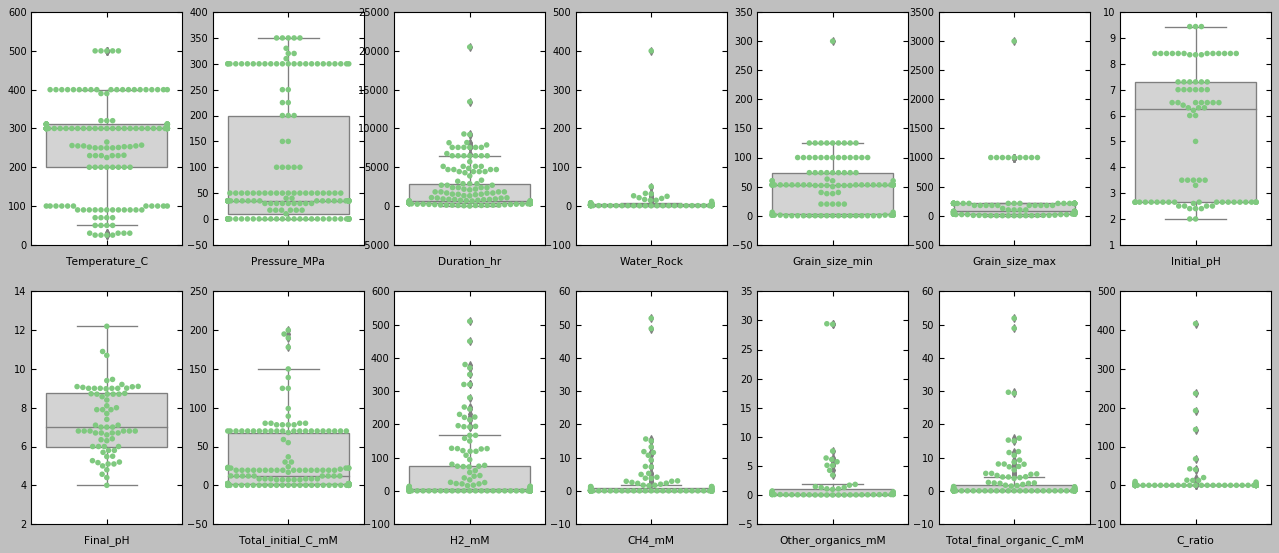

In [27]:
# Plot the results
sns.set_palette("Accent")
sns.set_context(context='paper')

fig, axs = plt.subplots(nrows=2, ncols=7, squeeze=False, sharey=False)
fig.set_size_inches(20, 8)

for i in range(len(ind)):
    col = ind[i]
    ax = axs[i//7, i%7]
    sns.swarmplot(y=dfreal.loc[dfreal[col] > -1, col], ax=ax)
    sns.boxplot(y=dfreal.loc[dfreal[col] > -1, col], ax=ax, color='lightgrey')
    ax.set_xlabel(ind[i])
    ax.set_ylabel('')
    ax.tick_params(axis="both",direction="in")
#     ax.set_ylim(top=dfreal[ind[i]].max(), bottom=0)
#     print(dfreal[ind[i]].max(), dfreal[ind[i]].min())

plt.savefig('./figures/swarmplot.svg', transparent=True)
# plt.savefig('violin_plot.png', dpi=500, transparent=True)

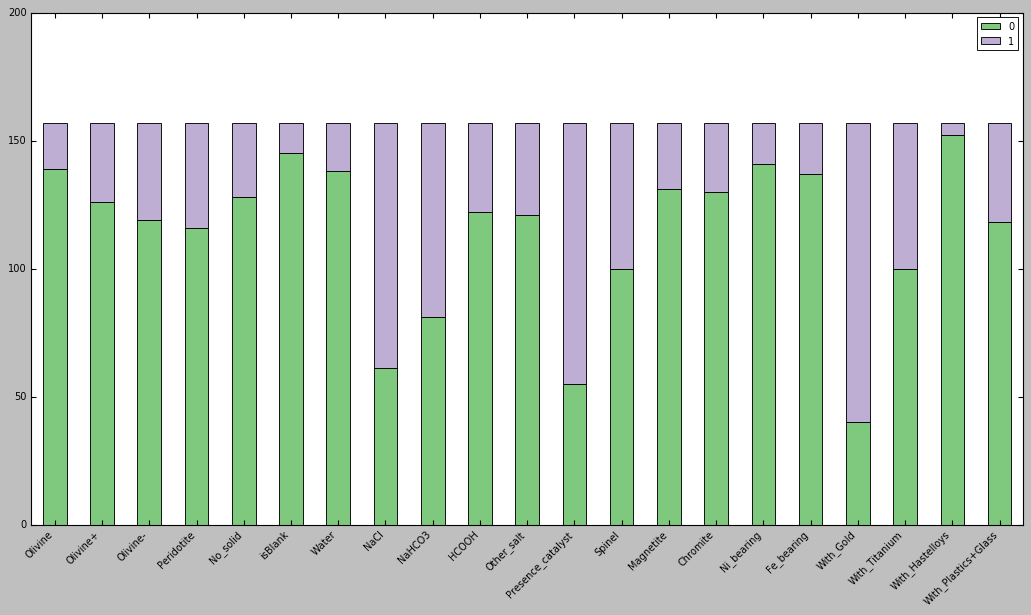

In [29]:
categorical = [i for i in property_mx.columns if i not in ind]
categorical.remove('Authors')
categorical.remove('No_of_experiments')
categorical.remove('Community_number')
categorical


catg = property_mx.loc[:, categorical]
cat_res = pd.DataFrame()
for i in categorical:
    cat_res[i] = catg.loc[:, i].value_counts()

cat_res.T.plot(kind='bar', stacked=True, figsize=(16,8))
plt.ylim(0, 200)
plt.xticks(rotation=45, ha='right')

plt.savefig('./figures/barplot_categorical.svg', transparent=True)
plt.show()

## test different experiment communities (commented out)

In [30]:
# for i in range(90,104):
#     pos = nx.spring_layout(G,seed=i)
#     #Draw graph
#     plt.style.use('classic')

#     plt.figure(figsize=(8,8)) #Increase graph size
#     nx.draw_networkx(G, pos, nodelist = nodes, edgelist = edges,
#                      with_labels = False, node_color = values, alpha = 1, cmap = "Accent")
#     nx.draw_networkx_labels(G, pos, font_size = 10)
#     plt.axis("off")
#     plt.title("Experiments communities")
#     plt.margins(0.09)
    
#     plt.show()

## Make color maps 

In [31]:
mpl.cm.get_cmap('Accent', 10)

## Define the plot function to visualize network in individual communities

In [32]:
def plotComm(G, colname, color, isLog=True, isRatio=False, ratio=False):
    #set up colormap and normalization
    node_col = np.array(property_mx[colname])
    col_cmap = mpl.cm.get_cmap(color, 10)
    if isLog:
        col_norm = mpl.colors.LogNorm(vmin = min(node_col[node_col > 0]), vmax = max(node_col))
    elif ratio:
         col_norm = mpl.colors.Normalize(vmin = min(node_col[node_col > 0]), vmax = 1)    
    else:
        col_norm = mpl.colors.Normalize(vmin = min(node_col[node_col > 0]), vmax = max(node_col))

    #color nodes (based on Temperature)
    node_colors = []
    
    if not ratio:
        for i, v in enumerate(node_col):
            if v > 0: #make sure value exists
                node_colors.append(col_cmap(col_norm(v))) #color node based on feature values
            elif v < 0: #color node red
                node_colors.append((1, 0, 0))
            elif colname == 'Community_number':
                node_colors.append(col_cmap(col_norm(v))) #color node based on feature values
            else: #color node white
                node_colors.append((1, 1, 1))
    else:
        for i, v in enumerate(node_col):
            if v <= 1 and v > 0: #make sure temp exists
                node_colors.append(col_cmap(col_norm(v))) #color node based on temp
            elif v < 0: #color node
                node_colors.append((1, 0, 0))
            elif v == 0: #color node white
                node_colors.append((1, 1, 1))
            else: #color node dard red (contamination)
                node_colors.append((1, 0.62, 0))#(0, 0, 1))

    # Define subplots
    fig, axs = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches((12,10))
    
    for i in range(0, max(values)+1): #cycle through each community
        ax = axs[i//2, i%2]
        g = nx.Graph()

        g_nodes = []
        g_colors = []
        for j, v in enumerate(values):
            if v == i:
                g_nodes.append(nodes[j])
                g_colors.append(node_colors[j]) #for h2 production
            
        g_edges = []
        for j, v in enumerate(edges):
            if v[0] in g_nodes and v[1] in g_nodes:
                g_edges.append(v)

        g.add_nodes_from(g_nodes)            
        g.add_weighted_edges_from(g_edges)


        g_pos = nx.spring_layout(g, seed=138)

        nx.draw_networkx(g, g_pos, nodelist = g_nodes, edgelist = g_edges, with_labels = False, 
                         node_color = g_colors, alpha = 1, ax=ax)
        nx.draw_networkx_labels(g, g_pos, font_size = 10, ax=ax)
        ax.axis("off")
        ax.set_title("Community {}".format(i))
        ax.margins(0.1)
        
#     #Draw colorbar
#     sm = plt.cm.ScalarMappable(cmap=col_cmap, norm=col_norm)
#     sm._A = []
#     cb = fig.colorbar(sm, fraction=0.05, pad=0.02, aspect = 5)
#     cb.set_label(colname)      

    plt.savefig('./figures/Z_community_{}.png'.format(colname), transparent=True)

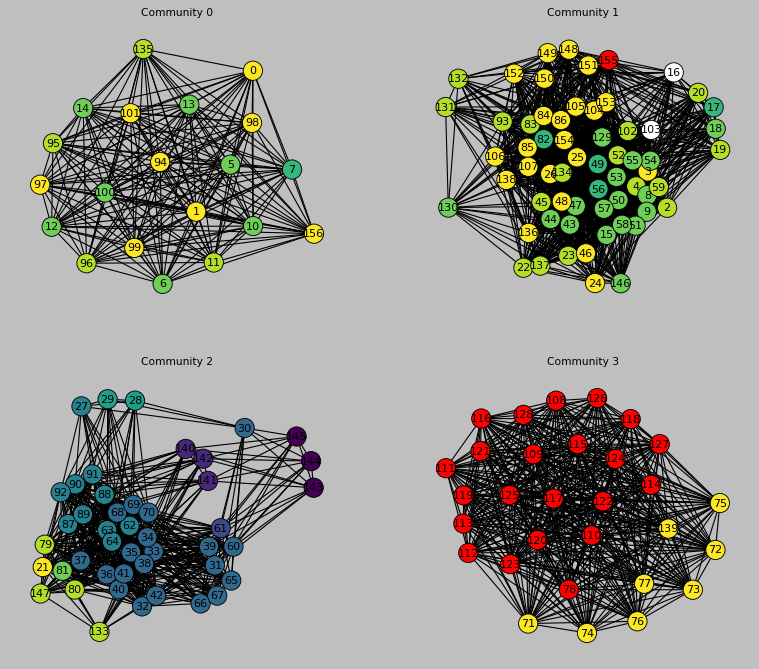

In [33]:
plotComm(G, 'H2_mM', color='viridis', isLog=True, ratio=False)

In [ ]:
for i in range(2,36):
    col = property_mx.columns[i]
    isLog = True
    color = 'viridis'
    if col in binaryList:
        color = 'Wistia'
    if col in nonLogList:
        isLog = False
    plotComm(G, col, color=color, isLog=isLog)

In [ ]:
plotComm(G, 'C_ratio', isLog=False, color='rainbow', ratio=True)